In [ ]:
from pathlib import Path
from warnings import simplefilter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split,KFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import jaccard_score

from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

from xgboost import XGBClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier

simplefilter('ignore')
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)

plt.style.use('ggplot')
plt.rc('figure',autolayout=True, figsize=(11,4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=18,
    titlepad=10
)

In [34]:
data_dir = Path('../data')

df_train = pd.read_parquet(
    data_dir / 'train_final.parquet'
)

df_test = pd.read_parquet(
    data_dir / 'test_final.parquet'
)

ss = pd.read_parquet(
    data_dir / 'submission_sample_final.parquet'
)

#### Feature Engineering

In [35]:
def binarize_targets(dataframe,menu_count = 9):
  unique_menus = ['menu' + str(i) for i in range(1,menu_count + 1)]
  dataframe[unique_menus] = 0
  for i,row in dataframe.iterrows():
    menus = row['target'].split(', ')
    for menu in menus:
        if menu in unique_menus:
            dataframe.loc[i,menu] = 1

  dataframe.drop('target',axis=1,inplace=True)

  return dataframe

def month_as_category(dataframe):
   dataframe['month'] = dataframe['month'].astype('object')

   return dataframe

def normalize_n_seconds(dataframe):
  dataframe['n_seconds'] = dataframe[['n_seconds_1','n_seconds_2','n_seconds_3']].sum(axis=1)

  for col in ['n_seconds_1','n_seconds_2','n_seconds_3']:
      dataframe[col] = dataframe[col] / dataframe['n_seconds']

  return dataframe


def change_carrier(carrier):
  if carrier not in ['TURKCELL','VODAFONE TR', 'TURK TELEKOM']:
    carrier = 'OTHER'

  return carrier

def change_device_brand(devicebrand):
  if devicebrand != 'Apple':
    devicebrand = 'Android'

  return devicebrand

def create_age_groups(dataframe):
  bins = [20,30,40,50,60,70,120]
  labels = ['20-29','30-39','40-49','50-59','60-69','70+']
  dataframe['age_group'] = pd.cut(dataframe.feature_49, bins, labels=labels, include_lowest=True)

  return dataframe

def encode_categoricals(dataframe,encoder,categorical_features):

   encoded_data = encoder.transform(dataframe[categorical_features])
   df_encoded = pd.concat(
      [
         dataframe.drop(categorical_features,axis=1),
         pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(categorical_features))
      ],
      axis=1
   )
   df_encoded[encoder.get_feature_names_out(categorical_features)] = df_encoded[encoder.get_feature_names_out(categorical_features)].astype(int)
   return df_encoded

df_train = binarize_targets(dataframe=df_train)

encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

for df in [df_train,df_test]:
  df = month_as_category(dataframe=df)
  df = normalize_n_seconds(dataframe=df)
  df['carrier'] = df['carrier'].apply(change_carrier)
  df['devicebrand'] = df['devicebrand'].apply(change_device_brand)
  df = create_age_groups(dataframe=df)


categorical_features = ['month','carrier','devicebrand','age_group']
encoder.fit(df_train[categorical_features])

df_train = encode_categoricals(dataframe=df_train, encoder=encoder,categorical_features=categorical_features)
df_test = encode_categoricals(dataframe=df_test, encoder=encoder,categorical_features=categorical_features)

print(f'Shape DF Train {df_train.shape}, Shape DF Test {df_test.shape}')

Shape DF Train (94049, 79), Shape DF Test (11955, 70)


#### Defining X,y

In [36]:
targets = ['menu1','menu2', 'menu3', 'menu4', 'menu5', 'menu6', 'menu7', 'menu8', 'menu9']
features = [col for col in df_train.columns.to_list() if col not in targets + ['id']]

X = df_train[features]
y = df_train[targets]

#### Evaluation Utils

In [37]:
def binarize_preds(preds):
    sorted_indices = np.argsort(preds, axis=1)[:, ::-1]
    binary_array = np.zeros_like(preds)
    
    for row, indices in enumerate(sorted_indices[:, :3]):
        binary_array[row, indices] = 1

    return binary_array.astype(int)

def evaluate_model(model,eval_set,y_true):
    y_pred = model.predict_proba(eval_set)
    y_pred = binarize_preds(preds=y_pred)

    js = jaccard_score(y_true,y_pred,average='micro') 

    return js

In [38]:
xgb_params = {
    'lambda': 0.002726063447574496, 
    'alpha': 0.0035451668057874825, 
    'colsample_bytree': 0.6,
    'subsample': 0.6, 
    'learning_rate': 0.016,
    'n_estimators': 275, 
    'max_depth': 15, 
    'random_state': 2020, 
    'min_child_weight': 37,
    'tree_method' : 'hist'}

kf = KFold(n_splits=7,random_state=925,shuffle=True)
jaccard_scores = []

for fold,(train_idx,test_idx) in enumerate(kf.split(X)):
    print('For fold: ', fold)

    X_train,X_val = X.iloc[train_idx,:],X.iloc[test_idx,:]
    y_train,y_val = y.iloc[train_idx],y.iloc[test_idx]
    print("Train shape:", X_train.shape, "|", "Val Shape:", X_val.shape)

    model = XGBClassifier(**xgb_params)

    model.fit(
        X_train,
        y_train,
        eval_set=[(X_val,y_val)],
        verbose = False
    )

    js = evaluate_model(
        model=model,
        eval_set=X_val,
        y_true=y_val
    )
    print('Fold Jaccard Score: ', js)
    jaccard_scores.append(js)

    print("\n", "*"*70, "\n")

For fold:  0


Train shape: (80613, 69) | Val Shape: (13436, 69)
Fold Jaccard Score:  0.5135175728446981

 ********************************************************************** 

For fold:  1
Train shape: (80613, 69) | Val Shape: (13436, 69)
Fold Jaccard Score:  0.5149966173043674

 ********************************************************************** 

For fold:  2
Train shape: (80613, 69) | Val Shape: (13436, 69)
Fold Jaccard Score:  0.5149396775284699

 ********************************************************************** 

For fold:  3
Train shape: (80613, 69) | Val Shape: (13436, 69)
Fold Jaccard Score:  0.5159367419470091

 ********************************************************************** 

For fold:  4
Train shape: (80614, 69) | Val Shape: (13435, 69)
Fold Jaccard Score:  0.5118721632469335

 ********************************************************************** 

For fold:  5
Train shape: (80614, 69) | Val Shape: (13435, 69)
Fold Jaccard Score:  0.5186797038376759

 ******************

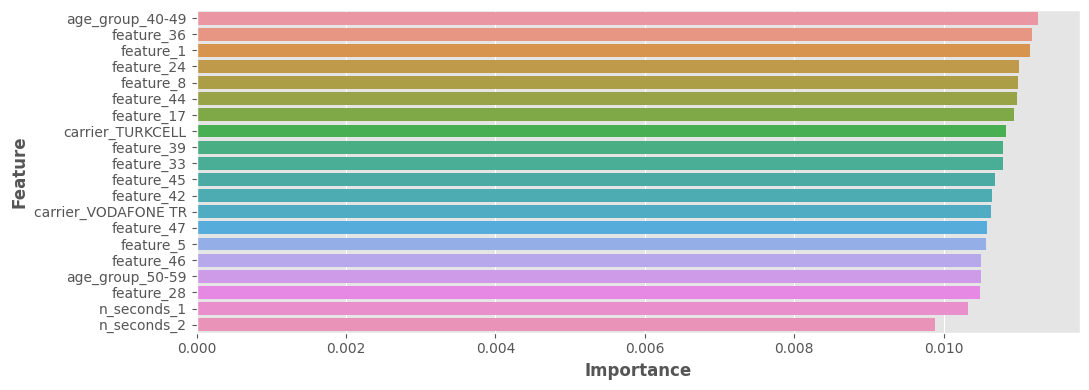

In [51]:
importance = model.feature_importances_

f_importance = pd.concat([
    pd.Series(X.columns.to_list(),name='Feature'),
    pd.Series(importance,name='Importance')
], axis=1).sort_values(by='Importance', ascending=False)

sns.barplot(data=f_importance.tail(20), x='Importance',y='Feature')

plt.show()